# Linear Regression

### Group number : 7
### Members:
   #### Abhilash Hemaraj: 001305283
   #### Sanghamitra Shanmugam: 001052134

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('fivethirtyeight')


class PrepareData:
    def __init__(self, filename):
        self.filename = filename
        #self.target_name_or_index = target_name_or_index

    def read_dataset(self, filename):
        return np.array(pd.read_csv(filename, header=None), dtype=np.float64)

    def split_data_train_test(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size=0.3,
                                                            random_state=0)
        return X_train, X_test, y_train, y_test

    def add_intercept(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)

        X_norm = (X - mean) / std
        X_norm = self.add_intercept(X_norm)

        return X_norm, mean, std

    def normalize_test(self, X, train_mean, train_std):
        X_norm = (X - train_mean) / train_std
        X_norm = self.add_intercept(X_norm)

        return X_norm

    def transform(self):
        df = self.read_dataset(self.filename)
        self.X = df[:, 0:-1]
        self.y = df[:, -1]
        #y = df[self.target_name_or_index]
        #X = df.drop(self.target_name_or_index, axis = 1)
        #self.y = np.array(y)
        #self.X = np.array(X)
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data_train_test(
        )
        self.X_train, self.mean, self.std = self.normalize_train(self.X_train)
        self.X_test = self.normalize_test(self.X_test, self.mean, self.std)
        return self.X_train, self.y_train, self.X_test, self.y_test


class LinearRegression:
    def __init__(self,
                 learning_rate,
                 lambda_value,
                 regularization,
                 max_iter,
                 tolerance,
                 method='ols, gd or sgd',
                 set_seed=7):
        self.learning_rate = learning_rate
        self.lambda_value = lambda_value
        self.regularization = regularization
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.method = method
        self.set_seed = set_seed

    def add_intercept(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def check_matrix_assumptions(self, X):
        x_rank = np.linalg.matrix_rank(X)

        if x_rank == min(X.shape[0], X.shape[1]):
            print('Matrix is full rank')
            self.full_rank = True
        else:
            print('Matrix is not full rank')
            self.full_rank = False

        if X.shape[0] < X.shape[1]:
            self.low_rank = True
            print('Data is low rank')
        else:
            self.low_rank = False
            print('Data is not low rank')

    def ols(self, X, y):
        if not self.regularization:
            w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            return w
        else:
            n = X.shape[1]
            I = np.eye((n))
            w = np.linalg.inv(X.T.dot(X) + self.lambda_value * I).dot(
                X.T).dot(y)
            return w

    def gradient_descent(self, X, y):
        self.error_history = []
        last_error = float('inf')
        for i in tqdm(range(self.max_iter)):
            self.w = self.w - self.learning_rate * self.cost_derivative(X, y)
            current_error = self.rmse(X, y)
            diff_error = last_error - current_error
            last_error = current_error

            self.error_history.append(current_error)
            if diff_error < self.tolerance:
                print("The model has converged")
                break

    def stochastic_gradient_descent(self, X, y):
        self.error_history = []
        last_error = float('inf')
        for i in tqdm(range(self.max_iter)):
            index = np.random.choice(X.shape[0],
                                     int(0.2 * X_train.shape[0]),
                                     replace=False)
            self.w = self.w - self.learning_rate * self.cost_derivative(
                X[index], y[index])
            current_error = self.rmse(X[index], y[index])
            diff_error = last_error - current_error
            last_error = current_error

            self.error_history.append(current_error)
            if abs(diff_error) < self.tolerance:
                print("The model has converged")
                break

    def predict(self, X):
        return X.dot(self.w)

    def sse(self, X, y):
        y_predicted = self.predict(X)
        #print(y_predicted)
        return ((y_predicted - y)**2).sum()

    def rmse(self, X, y):
        return np.sqrt((self.sse(X, y)) / X.shape[0])

    def score(self, X, y):
        print('Metrics with l2 Regularization:' if self.
              regularization else 'Metrics without Regularization')
        return print('RMSE test data:', self.rmse(X, y), '\n',
                     'SSE test data:', self.sse(X, y))

    def cost_derivative(self, X, y):
        y_predicted = self.predict(X)
        if not self.regularization:
            return (y_predicted - y).dot(X)
        else:
            return (y_predicted - y).dot(X) + (self.lambda_value * self.w)

    def plot_error_history(self, X, y):
        plt.figure(figsize=(12, 7))
        plt.plot(self.error_history)
        plt.title(r"Cost vs Epochs - {0} {1}".format(*[
            'Gradient Descent' if self.method ==
            'gd' else 'Stochastic Gradient Descent', 'with l2 Regularization'
            if self.regularization else 'without Regularization'
        ]))
        plt.xlabel("Epochs")
        plt.ylabel("Sum of Squared Errors")
        plt.text(x=int(len(self.error_history)*0.6),
                 y=np.max(self.error_history) * 0.7,
                 s=r'RMSE={0:.3f}'.format(self.rmse(X, y)),
                 fontsize=20,
                 color=[0, 158 / 255, 115 / 255],
                 weight='bold',
                 rotation=0,
                 backgroundcolor='#f0f0f0')
        #plt.show()

    def fit(self, X, y):
        # Setting the random seed for reproducability
        np.random.seed(self.set_seed)

        # check for assumptions for closed form solution
        self.check_matrix_assumptions(X)

        if self.full_rank and not self.low_rank and X.shape[
                0] < 10000 and self.method == 'ols':
            print(
                "Solving using closed form solution/ Ordinary Least Squares method",
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            self.w = self.ols(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))

        elif self.method == 'gd':
            print(
                'Solving using Batch Gradient Descent',
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            self.w = np.zeros(X.shape[1], dtype=np.float64)
            self.gradient_descent(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))
            self.plot_error_history(X, y)

        elif self.method == 'sgd':
            print(
                'Solving using Stochastic Gradient Descent',
                'with l2 Regularization'
                if self.regularization else 'without Regularization')
            #self.w = np.random.rand(X.shape[1], 1)
            self.w = np.zeros(X.shape[1], dtype=np.float64)
            self.stochastic_gradient_descent(X, y)
            print('RMSE:', self.rmse(X, y))
            print('SSE:', self.sse(X, y))
            self.plot_error_history(X, y)

## Concrete Dataset

In [2]:
Concrete_data = PrepareData(filename = 'concreteData.csv')

In [3]:
X_train, y_train, X_test, y_test = Concrete_data.transform()

In [4]:
ols_model = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
ols_model.fit(X_train, y_train)
ols_model.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method without Regularization
RMSE: 10.64860379952002
SSE: 81756.18203586874
Metrics without Regularization
RMSE test data: 9.67567754660951 
 SSE test data: 28928.189419662696


In [5]:
ols_model_reg = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
ols_model_reg.fit(X_train, y_train)
ols_model_reg.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method with l2 Regularization
RMSE: 10.64862861582118
SSE: 81756.56309773138
Metrics with l2 Regularization:
RMSE test data: 9.675842210449805 
 SSE test data: 28929.174046790347


Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 10.651608231644023
SSE: 81802.32246062765
Metrics without Regularization
RMSE test data: 9.664595037897913 
 SSE test data: 28861.95874918734


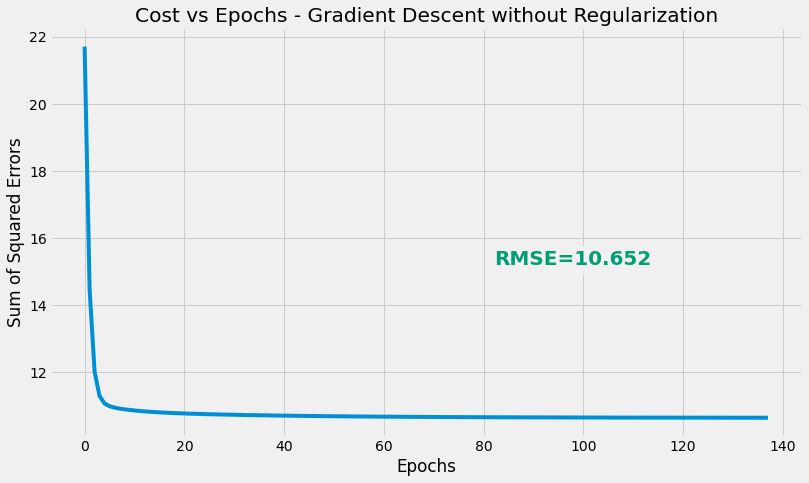

In [6]:
bgd_model = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgd_model.fit(X_train, y_train)
bgd_model.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 10.6519271692452
SSE: 81807.22129402982
Metrics with l2 Regularization:
RMSE test data: 9.665392850685416 
 SSE test data: 28866.72405804696


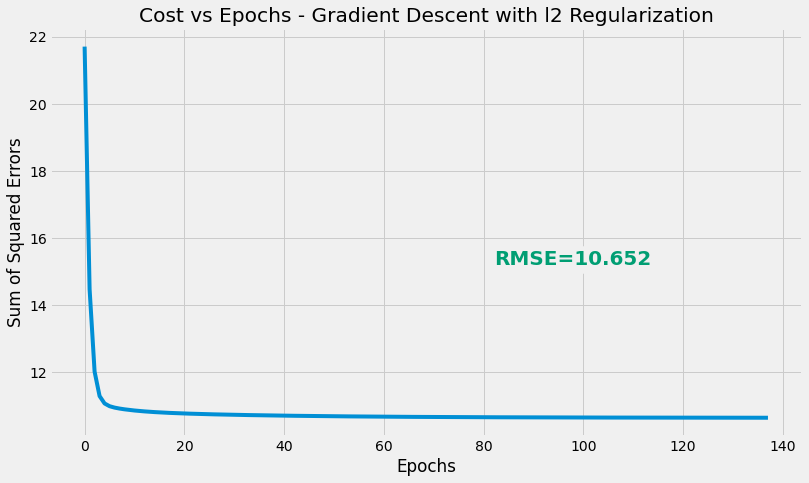

In [7]:
bgd_model_reg = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgd_model_reg.fit(X_train, y_train)
bgd_model_reg.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

RMSE: 10.67122248952237
SSE: 82103.86737246024
Metrics without Regularization
RMSE test data: 9.614065223745815 
 SSE test data: 28560.947289069543


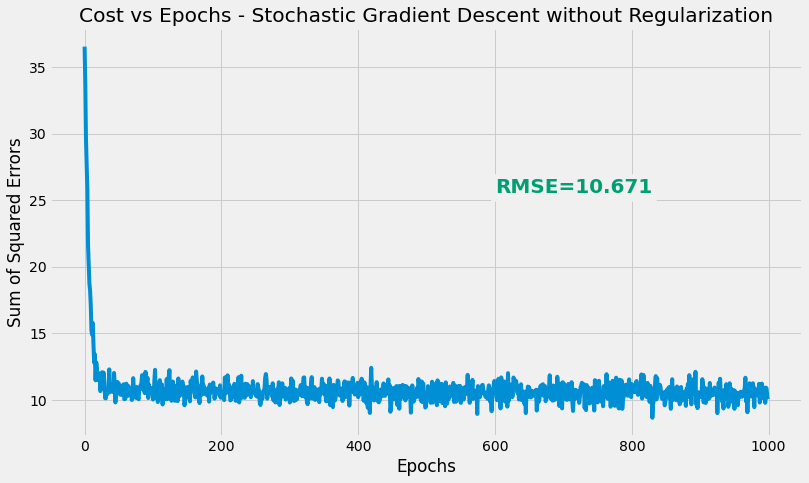

In [8]:
sgd_model = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.0001,
                             max_iter=1000,
                             method='sgd')

sgd_model.fit(X_train, y_train)
sgd_model.score(X_test, y_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent with l2 Regularization


  0%|          | 0/5000 [00:00<?, ?it/s]

The model has converged
RMSE: 10.670431794148147
SSE: 82091.70067964226
Metrics with l2 Regularization:
RMSE test data: 9.713447139692336 
 SSE test data: 29154.476098699542


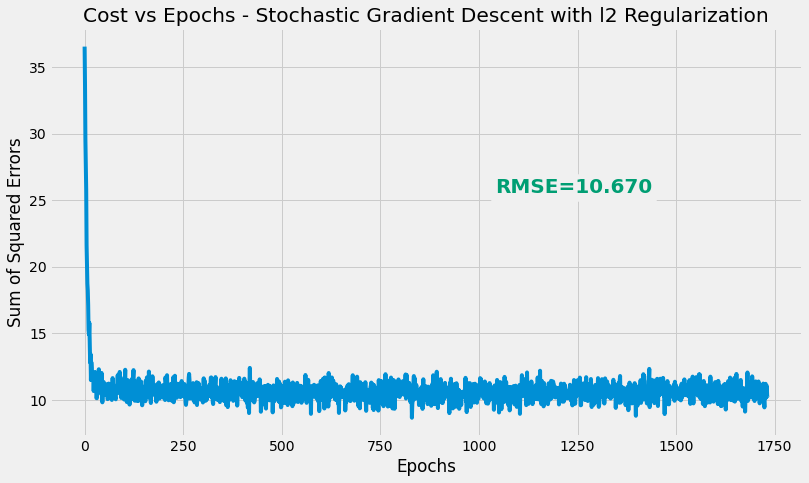

In [9]:
sgd_model_reg = LinearRegression(learning_rate=0.0007,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.0001,
                             max_iter=5000,
                             method='sgd')

sgd_model_reg.fit(X_train, y_train)
sgd_model_reg.score(X_test, y_test)

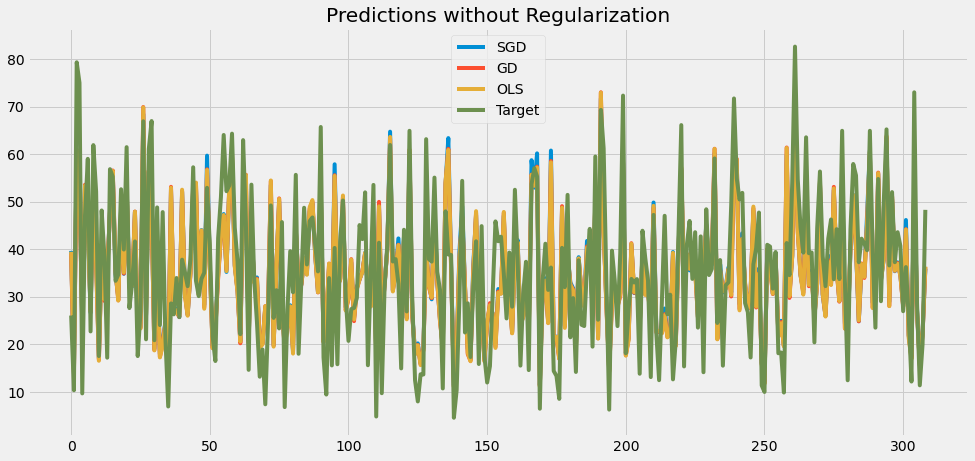

In [10]:
plt.figure(figsize = (15, 7))
plt.plot(sgd_model.predict(X_test), label = "SGD")
plt.plot(bgd_model.predict(X_test), label = "GD")
plt.plot(ols_model.predict(X_test), label = "OLS")
plt.plot(y_test, label = "Target")
plt.legend()
plt.title('Predictions without Regularization')
plt.show()

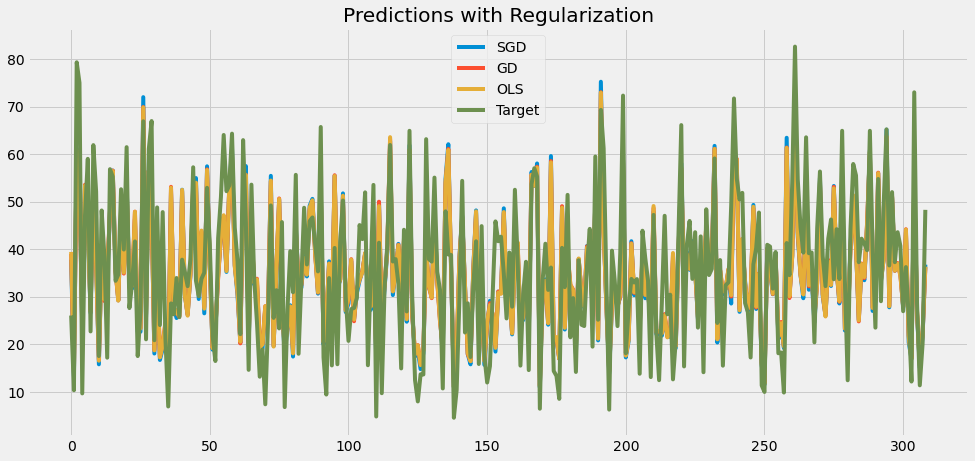

In [11]:
plt.figure(figsize = (15, 7))
plt.plot(sgd_model_reg.predict(X_test), label = "SGD")
plt.plot(bgd_model_reg.predict(X_test), label = "GD")
plt.plot(ols_model_reg.predict(X_test), label = "OLS")
plt.plot(y_test, label = "Target")
plt.legend()
plt.title('Predictions with Regularization')
plt.show()

## Yatch Dataset

In [12]:
yacht_data = PrepareData(filename = 'yachtData.csv')

In [13]:
X1_train, y1_train, X1_test, y1_test = yacht_data.transform()

In [14]:
olsy_model = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
olsy_model.fit(X1_train, y1_train)
olsy_model.score(X1_test, y1_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method without Regularization
RMSE: 9.012054802825176
SSE: 17461.68333036173
Metrics without Regularization
RMSE test data: 8.801947630790607 
 SSE test data: 7205.108234851776


In [15]:
olsy_model_reg = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.001,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
olsy_model_reg.fit(X1_train, y1_train)
olsy_model_reg.score(X1_test, y1_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method with l2 Regularization
RMSE: 9.01223236983644
SSE: 17462.371441904463
Metrics with l2 Regularization:
RMSE test data: 8.790303164108556 
 SSE test data: 7186.056963675131


Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 9.024131076769141
SSE: 17508.51246350277


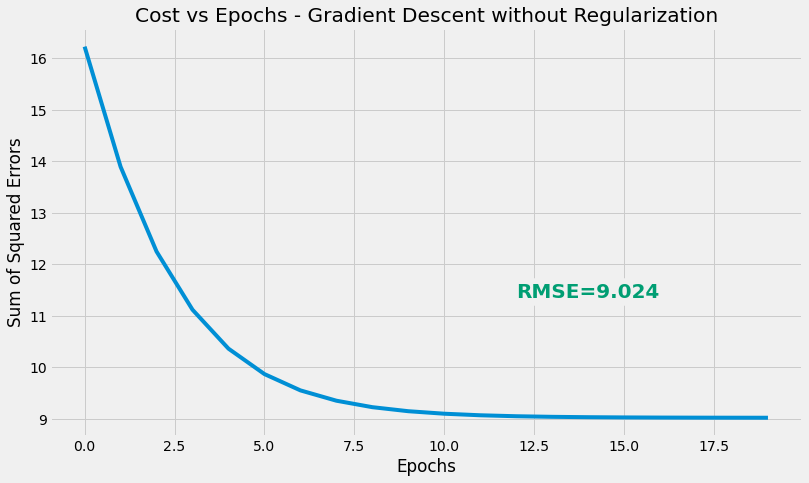

In [16]:
bgdy_model = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.001,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgdy_model.fit(X1_train, y1_train)

Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 9.024372031414195
SSE: 17509.447470694715
Metrics with l2 Regularization:
RMSE test data: 8.72091518355365 
 SSE test data: 7073.055632402504


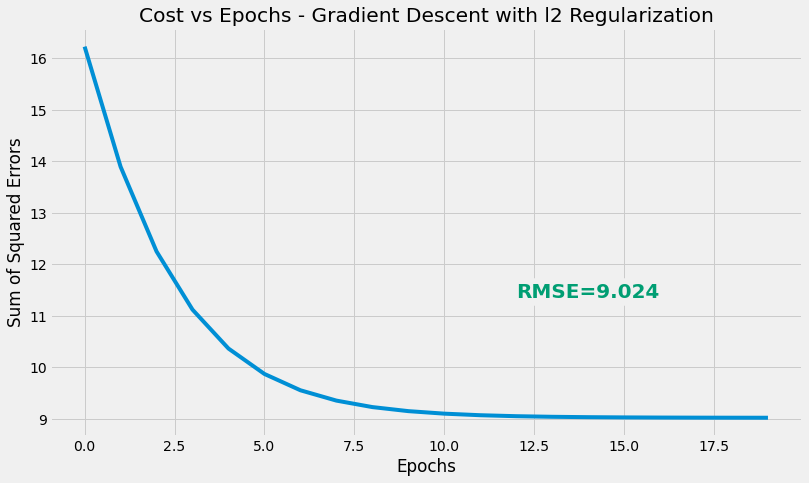

In [17]:
bgdy_model_reg = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.001,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgdy_model_reg.fit(X1_train, y1_train)
bgdy_model_reg.score(X1_test, y1_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 9.017287807309483
SSE: 17481.96807096824
Metrics without Regularization
RMSE test data: 8.822428310164911 
 SSE test data: 7238.6774397839345


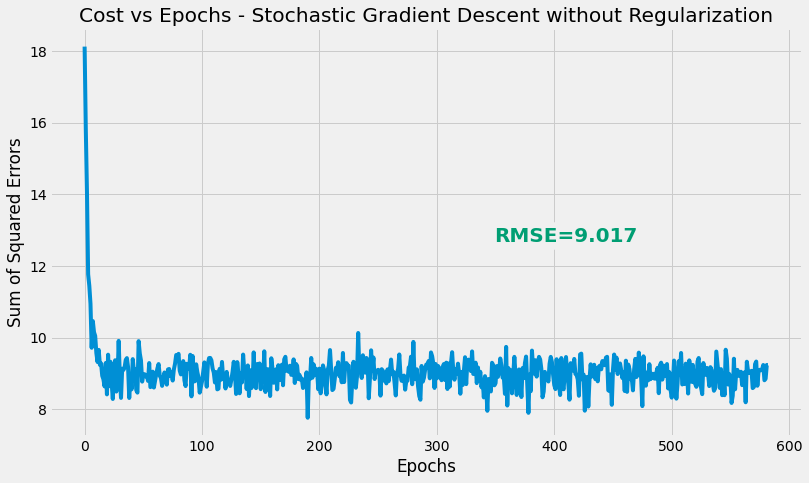

In [18]:
sgdy_model = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.001,
                             max_iter=1000,
                             method='sgd')

sgdy_model.fit(X1_train, y1_train)
sgdy_model.score(X1_test, y1_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 9.025614382867063
SSE: 17514.26872246661
Metrics with l2 Regularization:
RMSE test data: 8.82650413120222 
 SSE test data: 7245.367291566077


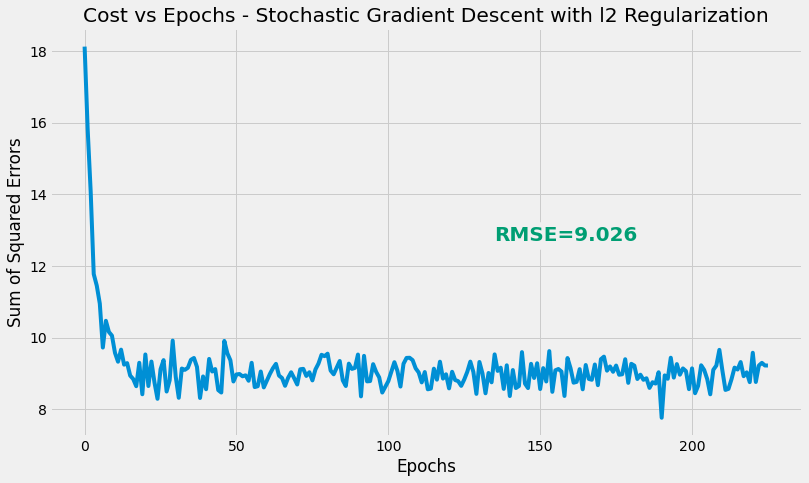

In [19]:
sgdy_model_reg = LinearRegression(learning_rate=0.001,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.001,
                             max_iter=1000,
                             method='sgd')

sgdy_model_reg.fit(X1_train, y1_train)
sgdy_model_reg.score(X1_test, y1_test)

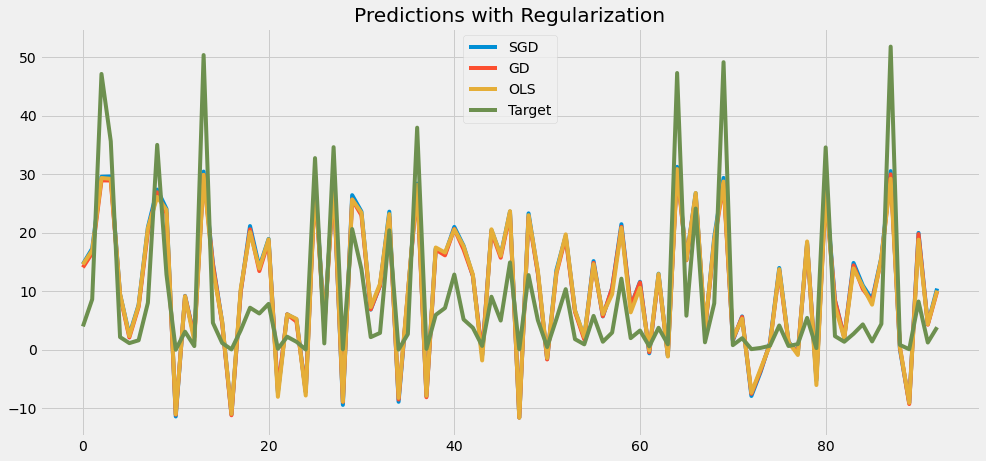

In [20]:
plt.figure(figsize = (15, 7))
plt.plot(sgdy_model_reg.predict(X1_test), label = "SGD")
plt.plot(bgdy_model_reg.predict(X1_test), label = "GD")
plt.plot(olsy_model_reg.predict(X1_test), label = "OLS")
plt.plot(y1_test, label = "Target")
plt.legend()
plt.title('Predictions with Regularization')
plt.show()

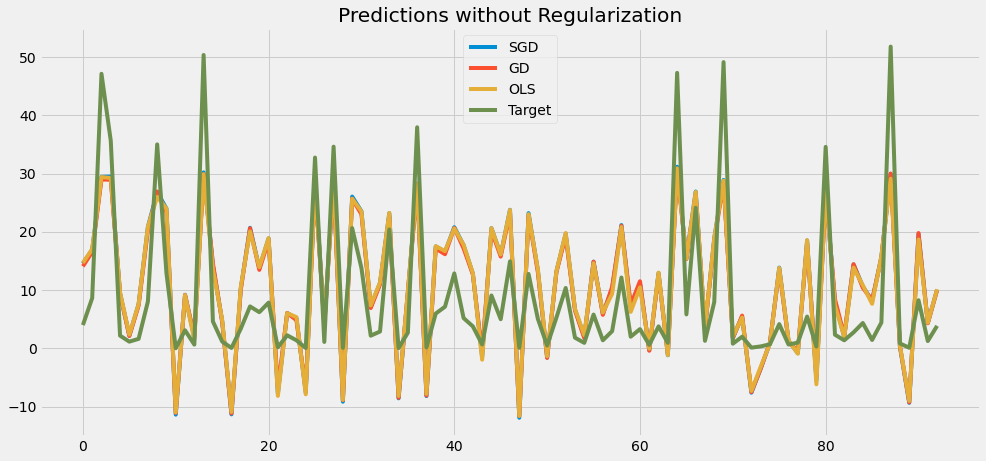

In [21]:
plt.figure(figsize = (15, 7))
plt.plot(sgdy_model.predict(X1_test), label = "SGD")
plt.plot(bgdy_model.predict(X1_test), label = "GD")
plt.plot(olsy_model.predict(X1_test), label = "OLS")
plt.plot(y1_test, label = "Target")
plt.legend()
plt.title('Predictions without Regularization')
plt.show()

## Housing Dataset

In [22]:
housing_data = PrepareData(filename = 'housing.csv')

In [23]:
X2_train, y2_train, X2_test, y2_test = housing_data.transform()

In [24]:
olsh_model = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.005,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
olsh_model.fit(X2_train, y2_train)
olsh_model.score(X2_test, y2_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method without Regularization
RMSE: 4.467466666510133
SSE: 7065.2234793982225
Metrics without Regularization
RMSE test data: 5.21497322491179 
 SSE test data: 4133.783751955125


In [25]:
olsh_model_reg = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.005,
                             max_iter=1000,
                             method='ols',
                             set_seed=7)
olsh_model_reg.fit(X2_train, y2_train)
olsh_model_reg.score(X2_test, y2_test)

Matrix is full rank
Data is not low rank
Solving using closed form solution/ Ordinary Least Squares method with l2 Regularization
RMSE: 4.467492801425105
SSE: 7065.306143497935
Metrics with l2 Regularization:
RMSE test data: 5.2165838571510035 
 SSE test data: 4136.337565080643


Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 4.551991601478355
SSE: 7335.102149135037
Metrics without Regularization
RMSE test data: 5.392911127207426 
 SSE test data: 4420.690544745565


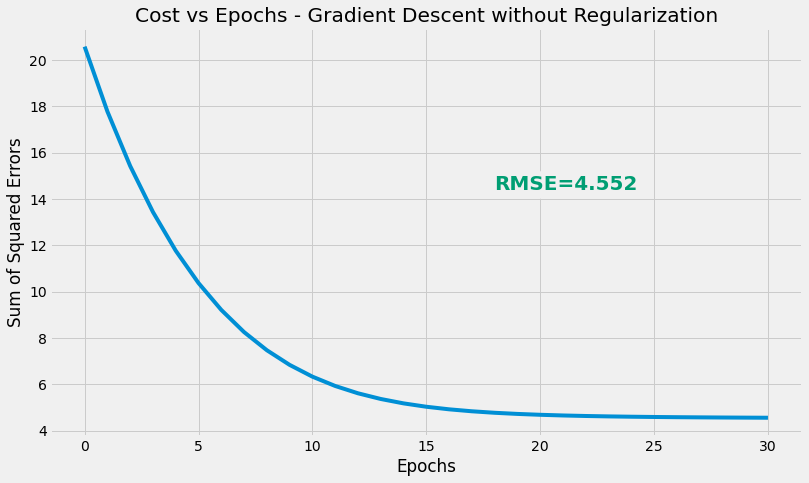

In [26]:
bgdh_model = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.005,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgdh_model.fit(X2_train, y2_train)
bgdh_model.score(X2_test, y2_test)

Matrix is full rank
Data is not low rank
Solving using Batch Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 4.5527021120649644
SSE: 7337.392168505078
Metrics with l2 Regularization:
RMSE test data: 5.394032788673232 
 SSE test data: 4422.529638242851


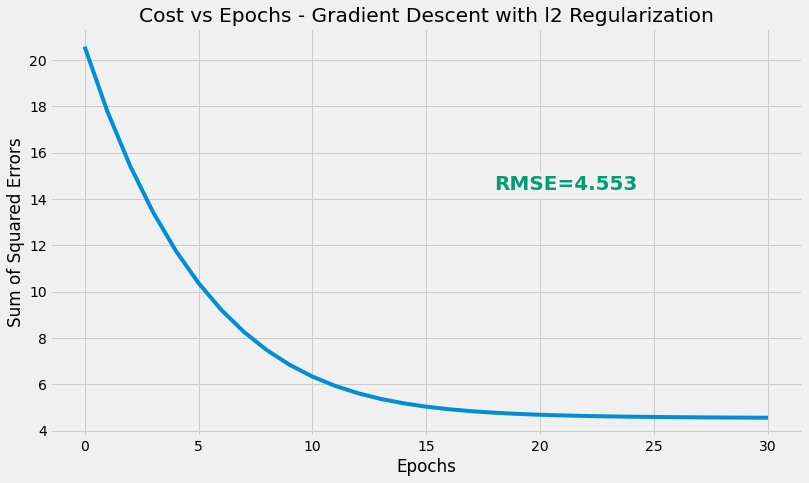

In [27]:
bgdh_model_reg = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.005,
                             max_iter=1000,
                             method='gd',
                             set_seed=7)
bgdh_model_reg.fit(X2_train, y2_train)
bgdh_model_reg.score(X2_test, y2_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent without Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 4.628829105022942
SSE: 7584.824844761651
Metrics without Regularization
RMSE test data: 5.485748583324967 
 SSE test data: 4574.202502956687


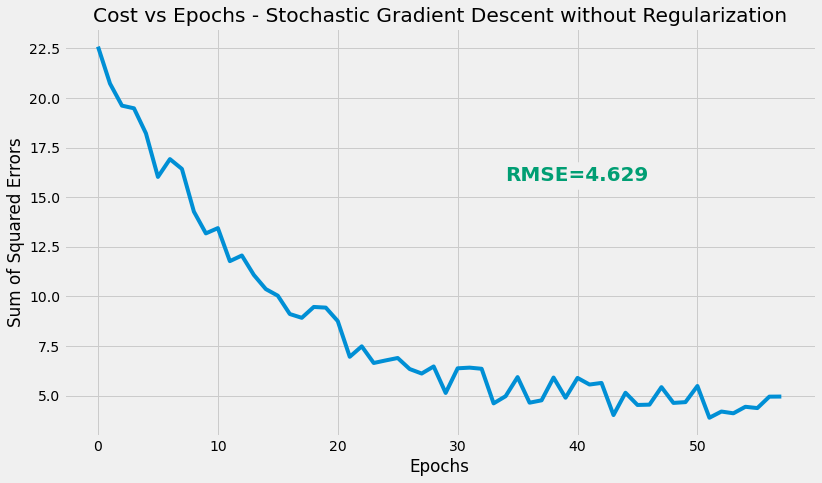

In [28]:
sgdh_model = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = False,
                             tolerance=0.005,
                             max_iter=1000,
                             method='sgd')

sgdh_model.fit(X2_train, y2_train)
sgdh_model.score(X2_test, y2_test)

Matrix is full rank
Data is not low rank
Solving using Stochastic Gradient Descent with l2 Regularization


  0%|          | 0/1000 [00:00<?, ?it/s]

The model has converged
RMSE: 4.480891667475906
SSE: 7107.7501080218735
Metrics with l2 Regularization:
RMSE test data: 5.285820350300575 
 SSE test data: 4246.864309899058


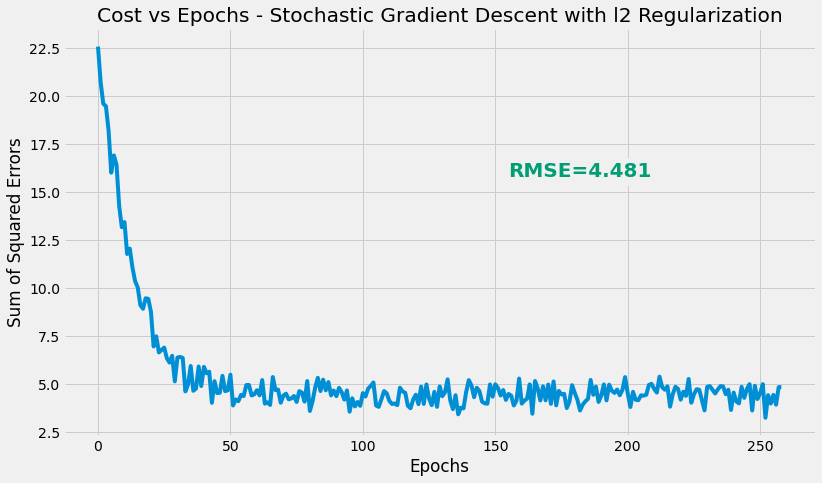

In [29]:
sgdh_model_reg = LinearRegression(learning_rate=0.0004,
                             lambda_value = 0.2,
                             regularization = True,
                             tolerance=0.005,
                             max_iter=1000,
                             method='sgd')

sgdh_model_reg.fit(X2_train, y2_train)
sgdh_model_reg.score(X2_test, y2_test)

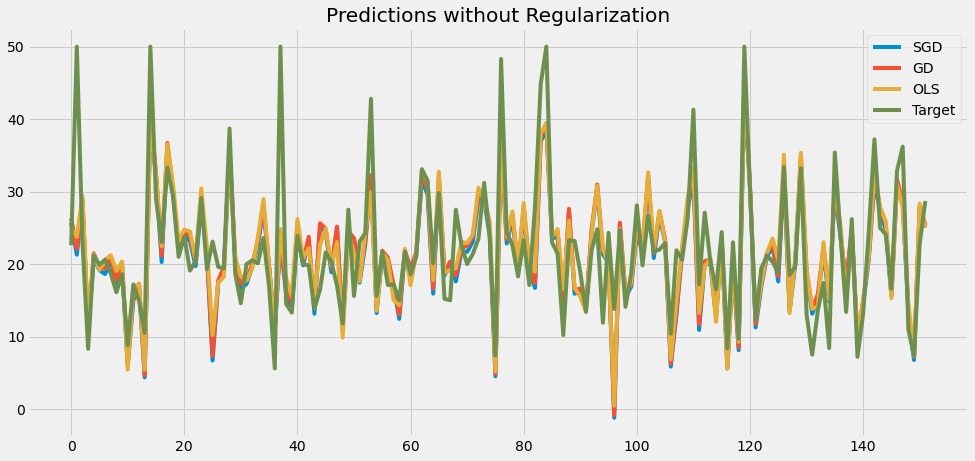

In [30]:
plt.figure(figsize = (15, 7))
plt.plot(sgdh_model.predict(X2_test), label = "SGD")
plt.plot(bgdh_model.predict(X2_test), label = "GD")
plt.plot(olsh_model.predict(X2_test), label = "OLS")
plt.plot(y2_test, label = "Target")
plt.legend()
plt.title('Predictions without Regularization')
plt.show()

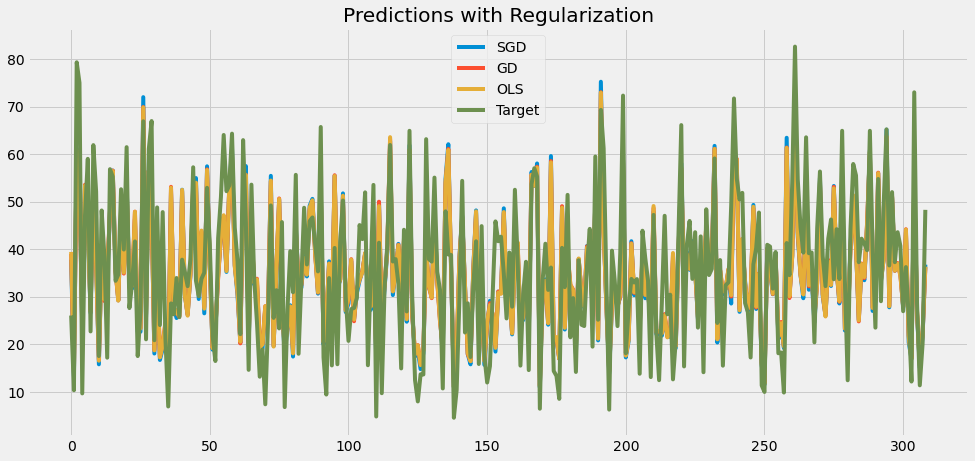

In [31]:
plt.figure(figsize = (15, 7))
plt.plot(sgd_model_reg.predict(X_test), label = "SGD")
plt.plot(bgd_model_reg.predict(X_test), label = "GD")
plt.plot(ols_model_reg.predict(X_test), label = "OLS")
plt.plot(y_test, label = "Target")
plt.legend()
plt.title('Predictions with Regularization')
plt.show()

<!-- # Report the RMSE and SSE over the test set for all three datasets -->

# Describe your observation and what are the effects of the learning rate and regularization parameters on the learning.



### Effect of learning rate:
Learning rate affects the training phase of the algorithm drastically. Too small a learning rate would make the model run for longer periods of time to reach an optimal solution. Too large learning rates would result in a non-optimal and unstable training, with errors fluctuating drastically. The right learning rate parameter would help the model reach optima in an appropriate amount of time depending on the dataset.

### Effect of Regularization:
Regularization is a way to penalize the complexity of the model. It enhances generalizability. if the lambda parameter is zero then it has no effect but if its 1 then you will most probably underfit your dataset as the model becomes too simple. So it is important to balance between having a fairly complex model and generalization.

### Observations from the exercise
We can see that stochastic gradient is almost always better than gradient descent as it is a robust way of training. Also tweaking the tolerance here will result in better coefficients because the model would run more iterations a fit better to the dataset.